In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from diffusers import StableDiffusionPipeline, DDPMScheduler
from transformers import CLIPTokenizer, CLIPTextModel
from torchvision import transforms
from PIL import Image
from datasets import load_dataset


In [2]:
class EmbeddingProjector(nn.Module):
    def __init__(self, input_dim=384, output_dim=768):
        super(EmbeddingProjector, self).__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)


In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset["train"]
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        if self.transform:
            image = self.transform(image)
        embedding = self.dataset[idx]["embedding_vector"]
        embedding = torch.tensor(embedding, dtype=torch.float32)
        return {"image": image, "embedding": embedding}

In [ ]:
pipeline = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5")
unet = pipeline.unet.to("cuda")
vae = pipeline.vae.to("cuda")
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder
scheduler = pipeline.scheduler

vae.eval()
unet.train()

#projector = EmbeddingProjector().to("cuda")

In [5]:
#optimizer = optim.AdamW(list(unet.parameters()) + list(projector.parameters()), lr=1e-5)
optimizer = optim.AdamW(unet.parameters(), lr=1e-5)
batch_size = 4
num_epochs = 10

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
dataset = load_dataset("Cilem/histopathology")
custom_dataset = CustomDataset(dataset, transform=transform)
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
""" def custom_forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
    encoder_hidden_states = projector(encoder_hidden_states)
    return self.original_forward(sample, timestep, encoder_hidden_states, cross_attention_kwargs)

unet.original_forward = unet.forward
unet.forward = custom_forward.__get__(unet) """

In [9]:
prompt = "a histopathology image"

In [ ]:
for epoch in range(num_epochs):
    for batch in dataloader:
        images = batch["image"].to("cuda")
        text = [prompt] * images.shape[0]
        text = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        encoder_hidden_states = text_encoder(**text).last_hidden_state
        encoder_hidden_states = encoder_hidden_states.to("cuda")
        #embeddings = batch["embedding"].to("cuda")  
        #projected_embeddings = projector(embeddings)

        latents = vae.encode(images).latent_dist.sample() 
        latents = latents * 0.18215 

        noise = torch.randn_like(latents).to("cuda") 
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (latents.shape[0],), device="cuda").long()

        noisy_latents = scheduler.add_noise(latents, noise, timesteps)  
        
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample

        loss = F.mse_loss(noise_pred, noise)
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

In [ ]:
# save the model
pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    scheduler=scheduler,
    tokenizer=pipeline.tokenizer,
    text_encoder=pipeline.text_encoder
)
pipe.save_pretrained("histopathology-diffusion")

# save the projector
#torch.save(projector.state_dict(), "projector.pth")

In [ ]:
trained_pipe = StableDiffusionPipeline.from_pretrained("./histopathology-diffusion_1")
trained_pipe = trained_pipe.to("cuda")
""" # load the projector
projector = EmbeddingProjector().to("cuda")
projector.load_state_dict(torch.load("projector.pth"))
projector.eval() # [B, 768] """

In [ ]:
""" embeddings = next(iter(dataloader))["embedding"].to("cuda")
print(embeddings.shape)  # [B, 384]
projected_embeddings = projector(embeddings)
print(projected_embeddings[0].unsqueeze(0).shape)  """

In [27]:
""" dummy_embed = torch.randn(1, 2, 768).to("cuda") """

In [ ]:
out = trained_pipe(
    prompt="a cat sitting on banch",
    num_images_per_prompt=4,
    num_inference_steps=10,
    guidance_scale=15
).images

display(out[0])
display(out[1])
display(out[2])
display(out[3])

In [ ]:
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

vae.requires_grad_(False)

In [ ]:
features = torch.tensor(dataset["train"][31500]["embedding_vector"])
current_length = features.shape[-1]
target_length = 768

repeat_times = (target_length // current_length) + 1
expanded_features = features.repeat(1, repeat_times)[:,:target_length]
print(expanded_features.shape)
print(features[0][0])
print(expanded_features[0][384])

In [5]:
dummy = torch.randn(1, 3, 768)

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", safety_checker=None)
tokenizer = pipe.tokenizer
prompt = " "
tokens = tokenizer(prompt, return_tensors="pt").input_ids
print(tokens)
text_encoder = pipe.text_encoder
embeds = text_encoder(tokens)[0]
print(embeds.shape)
dummy = torch.randn(1, 3, 768)
# add expanded_features to embeds 1 index
dummy[0][0] = embeds[0][0]
dummy[0][1] = expanded_features
dummy[0][2] = embeds[0][1]



pipe.to("cuda", torch.float16)
generator = torch.Generator(device="cuda").manual_seed(68764)
output = pipe(prompt_embeds=dummy,
              generator=generator,
              num_inference_steps=10,
              guidance_scale=8).images[0]

display(output)

In [1]:
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPTokenizer, CLIPTextModel, CLIPFeatureExtractor

import torch 

vae = AutoencoderKL.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="vae")
safety_checker = StableDiffusionSafetyChecker.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="safety_checker")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel(
    act_fn="silu",
    attention_head_dim=8,
    center_input_sample=False,
    downsample_padding=1,
    flip_sin_to_cos=True,
    freq_shift=0,
    mid_block_scale_factor=1,
    norm_eps=1e-05,
    norm_num_groups=32,
    sample_size=64, 
    in_channels=4, 
    out_channels=4, 
    layers_per_block=2, 
    block_out_channels=(320, 640, 1280, 1280), 
    down_block_types=(
    "CrossAttnDownBlock2D",
    "CrossAttnDownBlock2D",
    "CrossAttnDownBlock2D",
    "DownBlock2D"), 
    up_block_types=("UpBlock2D",
    "CrossAttnUpBlock2D",
    "CrossAttnUpBlock2D",
    "CrossAttnUpBlock2D"),
    cross_attention_dim=384
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
vae.to(device)
unet.to(device)

text_embeddings = torch.randn(1, 1, 384).to(device) 

optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)
epochs = 1

dummy_images = torch.randn(1, 3, 512, 512).to(device)

for epoch in range(epochs):
    images = dummy_images.to(device)
    latents = vae.encode(images).latent_dist.sample()

    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (latents.shape[0],), device=device)
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    pred_noise = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

    loss = torch.nn.functional.mse_loss(pred_noise, noise)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


2025-02-10 00:09:27.511459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 00:09:27.542780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 00:09:27.542832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 00:09:27.567815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 00:09:28.712754: W tensorflow/compiler/tf

Epoch 1/1, Loss: 1.0623376369476318


In [2]:
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline(
    vae=vae,
    unet=unet,
    scheduler=noise_scheduler,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor
)

pipe.save_pretrained("my-diffusion-model")

/home/cilem/anaconda3/envs/ai/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:221: FutureWarning: The configuration file of this scheduler: DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


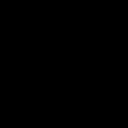

In [3]:
from diffusers import StableDiffusionPipeline
import torch
pipeline = StableDiffusionPipeline.from_pretrained("my-diffusion-model")

dummy_prompt = torch.randn(1, 1, 384).to("cuda:2")
output = pipeline(
    prompt_embeds=dummy_prompt,
    num_images_per_prompt=1,
    num_inference_steps=10,
    guidance_scale=0
).images

display(output[0])

In [4]:
output[0].size

(128, 128)